In [ ]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

# Baseline (Convolutional Neural Network)

In [1]:
%reset

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils import load_tensor

train_x, train_y = load_tensor("unaug", "64")
test_x, test_y = load_tensor("test", "64")

train_x.size(), train_y.size()

(torch.Size([5152, 3, 64, 64]), torch.Size([5152]))

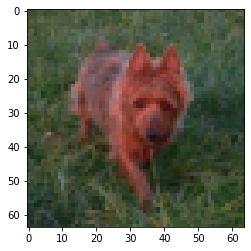

In [3]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x[idx])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

## Build CNN

A VGG-liked CNN Structure

In [6]:
class VGGConv2d(nn.Module):
    def __init__(self, is_dropout=False):
        super(VGGConv2d, self).__init__()

        conv_args = { "kernel_size": 3, "padding": 1 }
        pool_args = { "kernel_size": 2, "stride": 2 }

        self.bn = nn.BatchNorm2d(3, momentum=None, affine=False)

        # block 1: 3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Sequential(nn.Conv2d(3, 64, **conv_args), nn.ReLU())
        self.conv1b = nn.Sequential(nn.Conv2d(64, 64, **conv_args), nn.ReLU())
        self.pool1 = nn.MaxPool2d(**pool_args)

        # block 2: 64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Sequential(nn.Conv2d(64, 128, **conv_args), nn.ReLU())
        self.conv2b = nn.Sequential(nn.Conv2d(128, 128, **conv_args), nn.ReLU())
        self.pool2 = nn.MaxPool2d(**pool_args)

        # block 3: 128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Sequential(nn.Conv2d(128, 256, **conv_args), nn.ReLU())
        self.conv3b = nn.Sequential(nn.Conv2d(256, 256, **conv_args), nn.ReLU())
        self.pool3 = nn.MaxPool2d(**pool_args)
        
        # block 4: 256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Sequential(nn.Conv2d(256, 512, **conv_args), nn.ReLU())
        self.pool4 = nn.MaxPool2d(**pool_args)

        # block 5: 512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Sequential(nn.Conv2d(512, 512, **conv_args), nn.ReLU())
        self.pool5 = nn.MaxPool2d(**pool_args)

        # linear layers: 512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Sequential(nn.Linear(2048, 4096), nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU())
        self.linear3 = nn.Linear(4096, 10)

        # dropout layer
        self.dropout = nn.Dropout(0.25)
        self.is_dropout = is_dropout

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

    # take out the conv layers for feature extraction
    def features_conv(self, x):
        x = self.bn(x)
        
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool1(x)
        if self.is_dropout:
            x = self.dropout(x)

        x = self.conv2a(x)
        x = self.conv2b(x)
        x = self.pool2(x)
        if self.is_dropout:
            x = self.dropout(x)

        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.pool3(x)

        x = self.conv4a(x)

        return x

    def forward(self, x, is_need_hook=False):
        x = self.features_conv(x)
        x = self.pool4(x)

        x = self.conv5a(x) 
        x = self.pool5(x)
        if self.is_dropout:
            x = self.dropout(x)

        # Apply hook
        if is_need_hook:
            h = x.register_hook(self.activations_hook)

        x = x.contiguous()
        x = x.view(-1, 2048)
        x = self.linear1(x)
        if self.is_dropout:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.linear3(x)
        
        return x

Try to implement a baseline Efficient Net (EfficientNet-B0) network

In [ ]:
"""
class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.EfficientNetB4 = torchvision.models.efficientnet_b4(pretrained=False)
        self.EfficientNetB4 = self.EfficientNetB4.train()
        self.linear1 = nn.Linear(1000, 10)
    
    def forward(self, x):
        x = self.EfficientNetB4(x)
        x = nn.ReLU()(x)
        x = self.linear1(x)
        return x
"""

## Create Net instance

In [7]:
# net = EfficientNet()
net = VGGConv2d()
net
# print(net.EfficientNetB4)

VGGConv2d(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=None, affine=False, track_running_stats=True)
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv1b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2b): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv3b): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool3

### Training

In [8]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = VGGConv2d().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_unaug = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (3, 64, 64))
save_results(df_unaug, "baseline_cnn", "unaug", "64")

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (2f636b07):
epoch = 0	 loss = 2.181	 accuracy = 0.168	 test accuracy = 0.175
epoch = 10	 loss = 1.910	 accuracy = 0.305	 test accuracy = 0.267
epoch = 20	 loss = 1.558	 accuracy = 0.442	 test accuracy = 0.338
epoch = 30	 loss = 0.573	 accuracy = 0.803	 test accuracy = 0.350
epoch = 40	 loss = 0.027	 accuracy = 0.994	 test accuracy = 0.323


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 1 (88df2eeb):
epoch = 0	 loss = 2.178	 accuracy = 0.166	 test accuracy = 0.162
epoch = 10	 loss = 1.898	 accuracy = 0.296	 test accuracy = 0.287
epoch = 20	 loss = 1.539	 accuracy = 0.446	 test accuracy = 0.363
epoch = 30	 loss = 0.595	 accuracy = 0.792	 test accuracy = 0.355


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 2 (0a729238):
epoch = 0	 loss = 2.182	 accuracy = 0.165	 test accuracy = 0.162
epoch = 10	 loss = 1.905	 accuracy = 0.302	 test accuracy = 0.255
epoch = 20	 loss = 1.544	 accuracy = 0.448	 test accuracy = 0.350
epoch = 30	 loss = 0.624	 accuracy = 0.785	 test accuracy = 0.383


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 3 (381c619d):
epoch = 0	 loss = 2.177	 accuracy = 0.180	 test accuracy = 0.162
epoch = 10	 loss = 1.931	 accuracy = 0.281	 test accuracy = 0.277
epoch = 20	 loss = 1.533	 accuracy = 0.454	 test accuracy = 0.348


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 4 (c017e590):
epoch = 0	 loss = 2.174	 accuracy = 0.161	 test accuracy = 0.172
epoch = 10	 loss = 1.899	 accuracy = 0.302	 test accuracy = 0.282
epoch = 20	 loss = 1.532	 accuracy = 0.445	 test accuracy = 0.350
epoch = 30	 loss = 0.496	 accuracy = 0.832	 test accuracy = 0.338


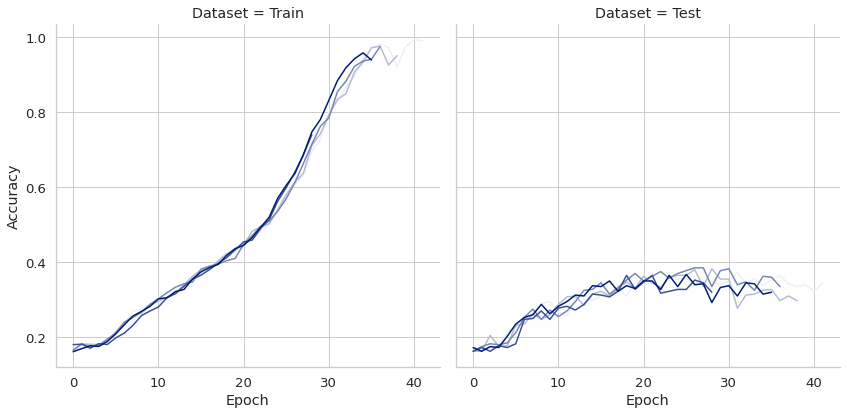

In [9]:
plot_experiments(df_unaug)

## Show final result on test set

In [22]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/home/wei2912/Workspace/Chen-Yiyang/cs4243_project/utils.py'>

In [8]:
from utils import load_checkpoint, eval_test_accuracy

net = VGGConv2d().to(device)
load_checkpoint(net, "c017e590") # to be manually updated

accuracy, pred_y, true_y = eval_test_accuracy(net, (test_x, test_y), (3, 64, 64))

F1 Score : 0.30693518877944076
Precision: 0.3145254582019288
Recall   : 0.3240024625862408


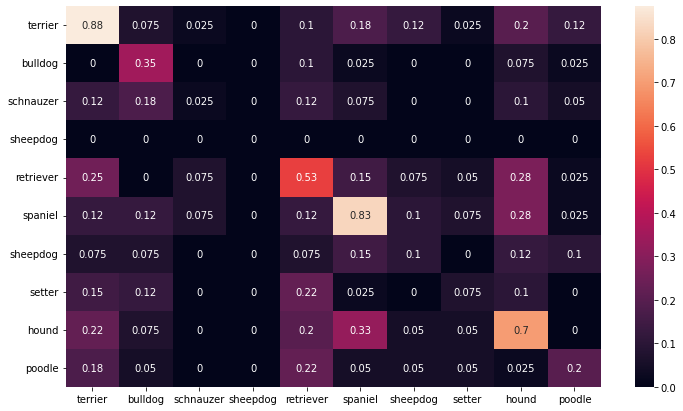

In [10]:
from utils import show_confusion_matrix, show_eval_metrics

show_confusion_matrix(pred_y, true_y)
show_eval_metrics(pred_y, true_y)

## Perform Grad-CAM on test instances

In [11]:
from utils import CLASSES

def show_prob(pred_score):
    prob = torch.softmax(pred_score.cpu(), dim=1)
    p = prob.data.squeeze().numpy()

    ft=15
    label = CLASSES
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()

In [30]:
from skimage.transform import resize
import cv2

def show_grad_cam(idx, num_channel=512):
    # display results
    img = test_x[idx]
    input = img.to(device).unsqueeze(0)
    pred_score = net.forward(input, True)

    # get gradients over activation and generate heatmap
    pred_label = pred_score.argmax(dim=1)[0]
    pred_score[0,pred_label].backward()

    # pull the gradients out of the model
    gradients = net.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = net.get_activations(input).detach()

    # weight the channels by corresponding gradients
    for i in range(num_channel):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze().to('cpu')
    
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    
    # normalize the heatmap
    heatmap /= torch.max(heatmap)


    # scale the heatmap back to same size as input and generate superposed img
    img_size = img.size(1)
    heatmap_large = image_resized = resize(heatmap, (img_size, img_size),
                       anti_aliasing=True)
    #plt.matshow(heatmap_large)

    # generate colour map
    heatmap_large = np.uint8(255 * heatmap_large)
    heatmap_large = cv2.applyColorMap(heatmap_large, cv2.COLORMAP_JET)

    # obtain superimposed img
    heatmap_large = torch.Tensor(heatmap_large).permute(2,0,1).float() / 255
    superimposed_img = torch.Tensor(heatmap_large).cpu() * 0.3 + img.cpu()
    superimposed_img = torch.clamp(superimposed_img, max=1)

    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 20))
    ax[0].imshow(img.cpu().permute(1,2,0))
    ax[0].set_title("Input img")
    ax[1].imshow(heatmap_large.permute(1,2,0))
    ax[1].set_title("Heatmap")
    ax[2].imshow(superimposed_img.permute(1,2,0))
    ax[2].set_title("Superimposed img")

    print("True label:", CLASSES[test_y[idx]])
    print("Pred label:", CLASSES[pred_label])

    show_prob(pred_score)


True label: schnauzer
Pred label: hound


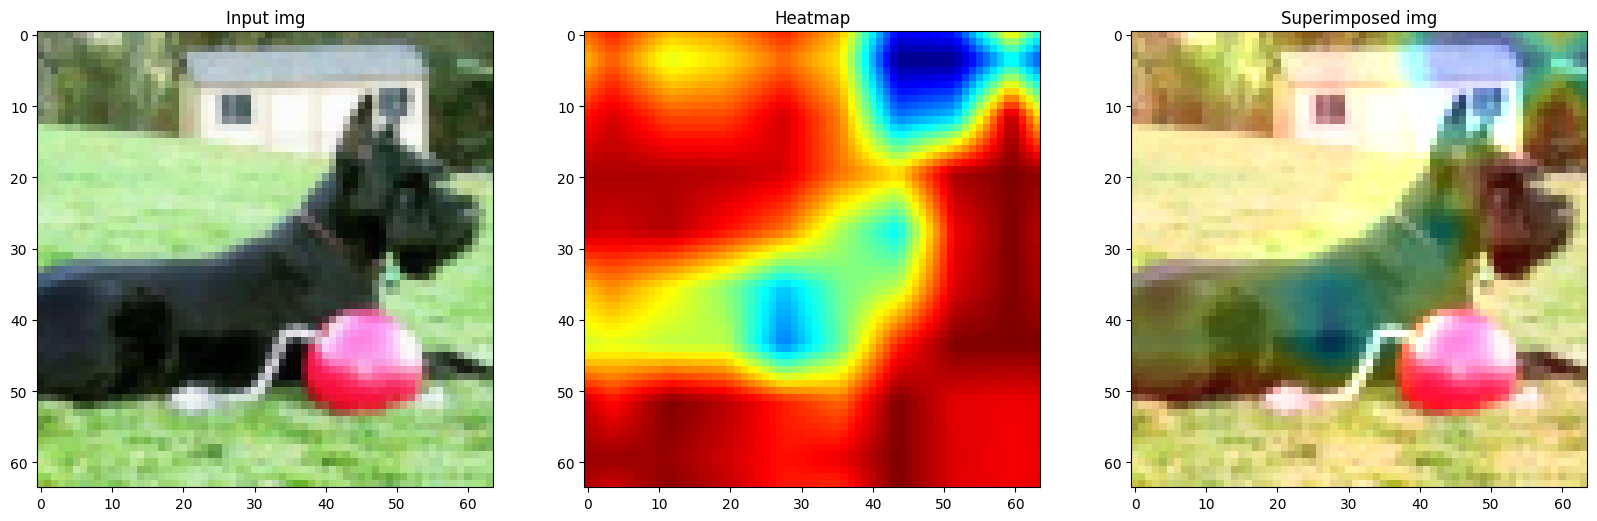

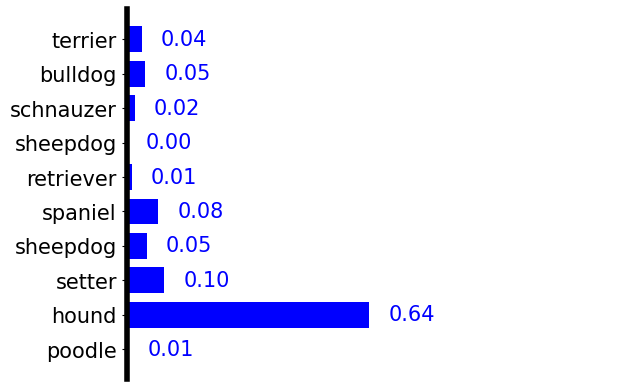

In [39]:
idx = np.random.randint(test_x.size(0))
show_grad_cam(idx=idx, num_channel=512)